In [1]:
work_dir = "projDir/"
# Temp dir
tmp_dir = "/home/ec2-user/"

# Scenic+

In [3]:
import dill
import scanpy as sc
import os
import warnings
warnings.filterwarnings("ignore")
import pandas
import pyranges
# Set stderr to null to avoid strange messages from ray
import sys
_stderr = sys.stderr
null = open(os.devnull,'wb')
work_dir = work_dir
tmp_dir = tmp_dir

adata = sc.read_h5ad('./adata.h5ad')
cistopic_obj = dill.load(open('./cistopic_obj.pkl'), 'rb')
menr = dill.load(open('./projDir/motifs/menr.pkl'), 'rb')

In [10]:
# adding predictedGroup_Un metadata to both scRNA and scATAC cisobject

adata.obs['predictedGroup_Un'] = adata.obs['celltype']

cistopic_obj.add_cell_data(cell_data, split_pattern='___')


In [12]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
import numpy as np

scplus_obj = create_SCENICPLUS_object(
        GEX_anndata = adata,
        cisTopic_obj = cistopic_obj,
        menr = menr,
        multi_ome_mode = False,
        key_to_group_by = 'predictedGroup_Un',
        nr_cells_per_metacells = 2 #the lower number will produce more observations
                                   )

2023-02-02 11:16:26,176 cisTopic     INFO     Imputing drop-outs
2023-02-02 11:16:27,896 cisTopic     INFO     Scaling
2023-02-02 11:16:28,989 cisTopic     INFO     Keep non zero rows
2023-02-02 11:16:30,467 cisTopic     INFO     Imputed accessibility sparsity: 0.05704200232880108
2023-02-02 11:16:30,468 cisTopic     INFO     Create CistopicImputedFeatures object
2023-02-02 11:16:30,469 cisTopic     INFO     Done!
2023-02-02 11:16:30,472 create scenicplus object INFO     Following annotations were found in both assays under key predictedGroup_Un:
	Intermediate Mesoderm, Postmitotic premature neurons, Primitive erythroid lineage, Chondrocytes & osteoblasts.
Keeping 8580 cells for RNA and 1392 for ATAC.
2023-02-02 11:16:36,776 create scenicplus object INFO     Automatically set `nr_metacells` to: Chondrocytes & osteoblasts: 192, Intermediate Mesoderm: 474, Postmitotic premature neurons: 260, Primitive erythroid lineage: 372
2023-02-02 11:16:36,777 create scenicplus object INFO     Genera

In [16]:
scplus_obj.gene_names

Index(['Gnai3', 'Cdc45', 'H19', 'Scml2', 'Apoh', 'Narf', 'Cav2', 'Klf6',
       'Scmh1', 'Cox5a',
       ...
       'Gm5905', 'Gm2516', '4933400L20Rik', 'A030001D20Rik', 'Gm7269',
       'Gm18991', 'Rnf223', '1700012D14Rik', 'Btbd8', '1700027J07Rik'],
      dtype='object', length=15460)

In [17]:
scplus_obj.metadata_regions.head()


,Chromosome,Start,End,Width,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc
GL456211.1:85802-86302,GL456211.1,85802,86302,500,23,1.361728,22,1.342423
GL456211.1:112142-112642,GL456211.1,112142,112642,500,28,1.447158,28,1.447158
GL456211.1:114701-115201,GL456211.1,114701,115201,500,22,1.342423,21,1.322219
GL456211.1:125113-125613,GL456211.1,125113,125613,500,25,1.397940,25,1.397940
GL456211.1:135291-135791,GL456211.1,135291,135791,500,20,1.301030,20,1.301030


In [18]:
scplus_obj.uns.keys()

dict_keys([])

In [19]:
ensembl_version_dict = {'105': 'http://www.ensembl.org',
                        '104': 'http://may2021.archive.ensembl.org/',
                        '103': 'http://feb2021.archive.ensembl.org/',
                        '102': 'http://nov2020.archive.ensembl.org/',
                        '101': 'http://aug2020.archive.ensembl.org/',
                        '100': 'http://apr2020.archive.ensembl.org/',
                        '99': 'http://jan2020.archive.ensembl.org/',
                        '98': 'http://sep2019.archive.ensembl.org/',
                        '97': 'http://jul2019.archive.ensembl.org/',
                        '96': 'http://apr2019.archive.ensembl.org/',
                        '95': 'http://jan2019.archive.ensembl.org/',
                        '94': 'http://oct2018.archive.ensembl.org/',
                        '93': 'http://jul2018.archive.ensembl.org/',
                        '92': 'http://apr2018.archive.ensembl.org/',
                        '91': 'http://dec2017.archive.ensembl.org/',
                        '90': 'http://aug2017.archive.ensembl.org/',
                        '89': 'http://may2017.archive.ensembl.org/',
                        '88': 'http://mar2017.archive.ensembl.org/',
                        '87': 'http://dec2016.archive.ensembl.org/',
                        '86': 'http://oct2016.archive.ensembl.org/',
                        '80': 'http://may2015.archive.ensembl.org/',
                        '77': 'http://oct2014.archive.ensembl.org/',
                        '75': 'http://feb2014.archive.ensembl.org/',
                        '54': 'http://may2009.archive.ensembl.org/'}

import pybiomart as pbm
def test_ensembl_host(scplus_obj, host, species):
    dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
    annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
    annot.columns = ['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    annot['Chromosome'] = annot['Chromosome'].astype('str')
    filter = annot['Chromosome'].str.contains('CHR|GL|JH|MT')
    annot = annot[~filter]
    annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    gene_names_release = set(annot['Gene'].tolist())
    ov=len([x for x in scplus_obj.gene_names if x in gene_names_release])
    print('Genes recovered: ' + str(ov) + ' out of ' + str(len(scplus_obj.gene_names)))
    return ov

n_overlap = {}
for version in ensembl_version_dict.keys():
    print(f'host: {version}')
    try:
        n_overlap[version] =  test_ensembl_host(scplus_obj, ensembl_version_dict[version], 'mmusculus')  ### hsapiens
    except:
        print('Host not reachable')
v = sorted(n_overlap.items(), key=lambda item: item[1], reverse=True)[0][0]
print(f"version: {v} has the largest overlap, use {ensembl_version_dict[v]} as biomart host")

host: 105
Genes recovered: 15438 out of 15460
host: 104
Genes recovered: 15430 out of 15460
host: 103
Genes recovered: 15428 out of 15460
host: 102
Genes recovered: 15449 out of 15460
host: 101
Genes recovered: 15449 out of 15460
host: 100
Genes recovered: 15449 out of 15460
host: 99
Genes recovered: 15448 out of 15460
host: 98
Genes recovered: 15450 out of 15460
host: 97
Genes recovered: 15451 out of 15460
host: 96
Genes recovered: 15447 out of 15460
host: 95
Genes recovered: 15449 out of 15460
host: 94
Genes recovered: 15451 out of 15460
host: 93
Genes recovered: 15450 out of 15460
host: 92
Genes recovered: 15445 out of 15460
host: 91
Genes recovered: 15453 out of 15460
host: 90
Host not reachable
host: 89
Host not reachable
host: 88
Host not reachable
host: 87
Host not reachable
host: 86
Host not reachable
host: 80
Genes recovered: 15103 out of 15460
host: 77
Genes recovered: 14846 out of 15460
host: 75
Host not reachable
host: 54
Host not reachable
version: 91 has the largest overl

In [20]:
biomart_host = "http://dec2017.archive.ensembl.org/"


In [23]:
!sudo wget -O ./allTFs_mm.txt https://resources.aertslab.org/cistarget/tf_lists/allTFs_mm.txt

--2023-02-02 11:18:45--  https://resources.aertslab.org/cistarget/tf_lists/allTFs_mm.txt
Resolving resources.aertslab.org (resources.aertslab.org)... 134.58.50.9
Connecting to resources.aertslab.org (resources.aertslab.org)|134.58.50.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11726 (11K) [text/plain]
Saving to: ‘./allTFs_mm.txt’

100%[======================================>] 11,726      --.-K/s   in 0s      

2023-02-02 11:18:45 (25.3 MB/s) - ‘./allTFs_mm.txt’ saved [11726/11726]



In [22]:
# !sudo pip install pyarrow==0.16.0

In [24]:
from scenicplus.wrappers.run_scenicplus import run_scenicplus
try:
    sys.stderr = open(os.devnull, "w")  # silence stderr
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['predictedGroup_Un'],
        species = 'mmusculus',
        assembly = 'mm10',
        tf_file = 'allTFs_mm.txt',
        save_path = os.path.join(work_dir, 'scenicplus'),
        biomart_host = biomart_host,
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = False,
        calculate_DEGs_DARs = False,
        export_to_loom_file = False,
        export_to_UCSC_file = False,
        n_cpu = 5,
        _temp_dir = os.path.join(tmp_dir, 'ray_spill'))
    sys.stderr = sys.__stderr__  # unsilence stderr
except Exception as e:
    #in case of failure, still save the object
    dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)
    raise(e)

2023-02-02 11:18:57,199 SCENIC+_wrapper INFO     projDir/scenicplus folder already exists.
2023-02-02 11:18:57,200 SCENIC+_wrapper INFO     Merging cistromes
2023-02-02 11:19:24,899 SCENIC+_wrapper INFO     Getting search space
2023-02-02 11:19:26,431 R2G          INFO     Downloading gene annotation from biomart dataset: mmusculus_gene_ensembl
2023-02-02 11:19:39,783 R2G          INFO     Downloading chromosome sizes from: http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes
2023-02-02 11:19:40,697 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2023-02-02 11:19:41,481 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2023-02-02 11:19:46,099 R2G          INFO     Intersecting with regions.
2023-02-02 11:19:47,522 R2G          INFO     Calculating distances from region to gene
2023-02-02 11:23:01,630 R2G 

100%|██████████| 199/199 [00:34<00:00,  5.69it/s] 


In [25]:
scplus_obj.uns.keys()

dict_keys(['Cistromes', 'search_space', 'region_to_gene', 'TF2G_adj', 'eRegulons', 'eRegulon_metadata', 'eRegulon_signatures', 'eRegulon_AUC', 'eRegulon_AUC_thresholds', 'RSS'])

# Simplifying and filtering SCENIC+ output

In [26]:
import dill
import scanpy as sc
import os
import warnings
warnings.filterwarnings("ignore")
import pandas
import pyranges
# Set stderr to null to avoid strange messages from ray
import sys
_stderr = sys.stderr
null = open(os.devnull,'wb')


In [27]:
import pickle
infile = open('./projDir/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [28]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)
scplus_obj.uns['eRegulon_metadata_filtered'].head()

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,Alx1_+_(74r),Alx1_+_(54g),Alx1,False,chr4:154693601-154694101,Prdm16,0.004729,0.259952,0.001229,0.001229,9.508363,1,0.280254,2.664753,2.664753,Alx1_+_+
1,Alx1_+_(74r),Alx1_+_(54g),Alx1,False,chr4:154409156-154409656,Prdm16,0.006363,0.263350,0.001676,0.001676,9.508363,1,0.280254,2.664753,2.664753,Alx1_+_+
2,Alx1_+_(74r),Alx1_+_(54g),Alx1,False,chr4:154625371-154625871,Prdm16,0.001139,0.244425,0.000278,0.000278,9.508363,1,0.280254,2.664753,2.664753,Alx1_+_+
3,Alx1_+_(74r),Alx1_+_(54g),Alx1,False,chr4:154450199-154450699,Prdm16,0.001279,0.257075,0.000329,0.000329,9.508363,1,0.280254,2.664753,2.664753,Alx1_+_+
4,Alx1_+_(74r),Alx1_+_(54g),Alx1,False,chr4:154461652-154462152,Prdm16,0.000473,0.172587,0.000082,0.000082,9.508363,1,0.280254,2.664753,2.664753,Alx1_+_+


In [30]:
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function

score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 3)
score_eRegulons(scplus_obj,
                ranking = gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 3)

In [31]:
scplus_obj.uns.keys()

dict_keys(['Cistromes', 'search_space', 'region_to_gene', 'TF2G_adj', 'eRegulons', 'eRegulon_metadata', 'eRegulon_signatures', 'eRegulon_AUC', 'eRegulon_AUC_thresholds', 'RSS', 'eRegulon_metadata_filtered', 'eRegulon_signatures_filtered', 'eRegulon_AUC_filtered'])

# Get high quality eRegulons based on TF expression-to-AUC value correlation

In [33]:
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'predictedGroup_Un',
        auc_key = 'eRegulon_AUC_filtered',
#     auc_key = 'eRegulon_AUC',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'predictedGroup_Un',
        auc_key = 'eRegulon_AUC_filtered',
#     auc_key = 'eRegulon_AUC',
        signature_key = 'Region_based')

####    Get correlation between gene expression and cistrome accessibility

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'predictedGroup_Un',
            auc_key = 'eRegulon_AUC_filtered',
#     auc_key = 'eRegulon_AUC',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'predictedGroup_Un',
            auc_key = 'eRegulon_AUC_filtered',
#     auc_key = 'eRegulon_AUC',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

In [34]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']


,TF,Cistrome,Rho,P-value,Adjusted_p-value
0,Brca1,Brca1_extended_+_(105r),0.313882,1.353979e-10,3.384948e-10
1,Tcf4,Tcf4_extended_-_(71r),-0.851084,2.016383e-113,4.940138e-112
2,Lhx4,Lhx4_+_(16r),-0.092314,6.511911e-02,8.309470e-02
3,Pbx1,Pbx1_+_(178r),0.624345,1.295953e-44,7.055746e-44
4,Hmga2,Hmga2_+_(76r),0.680213,1.209436e-55,8.466050e-55
...,...,...,...,...,...
240,Elk4,Elk4_+_(79r),0.000251,9.960137e-01,9.960137e-01
241,Mecp2,Mecp2_+_(42r),0.134455,7.082941e-03,1.058122e-02
242,Egr1,Egr1_+_(109r),0.150343,2.573089e-03,3.915571e-03
243,Zfp148,Zfp148_-_(84r),-0.593454,2.017219e-39,9.504203e-39


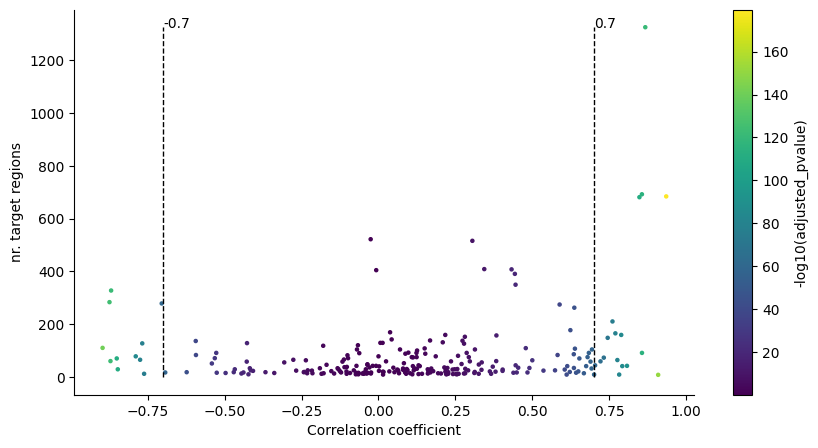

In [35]:
import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.70, 0.70],
        'n_targets': 0
}
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

In [36]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
#         x for x in scplus_obj.uns['eRegulon_signatures']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
#         x for x in scplus_obj.uns['eRegulon_signatures']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 29 eRegulons


# Plot dotplot

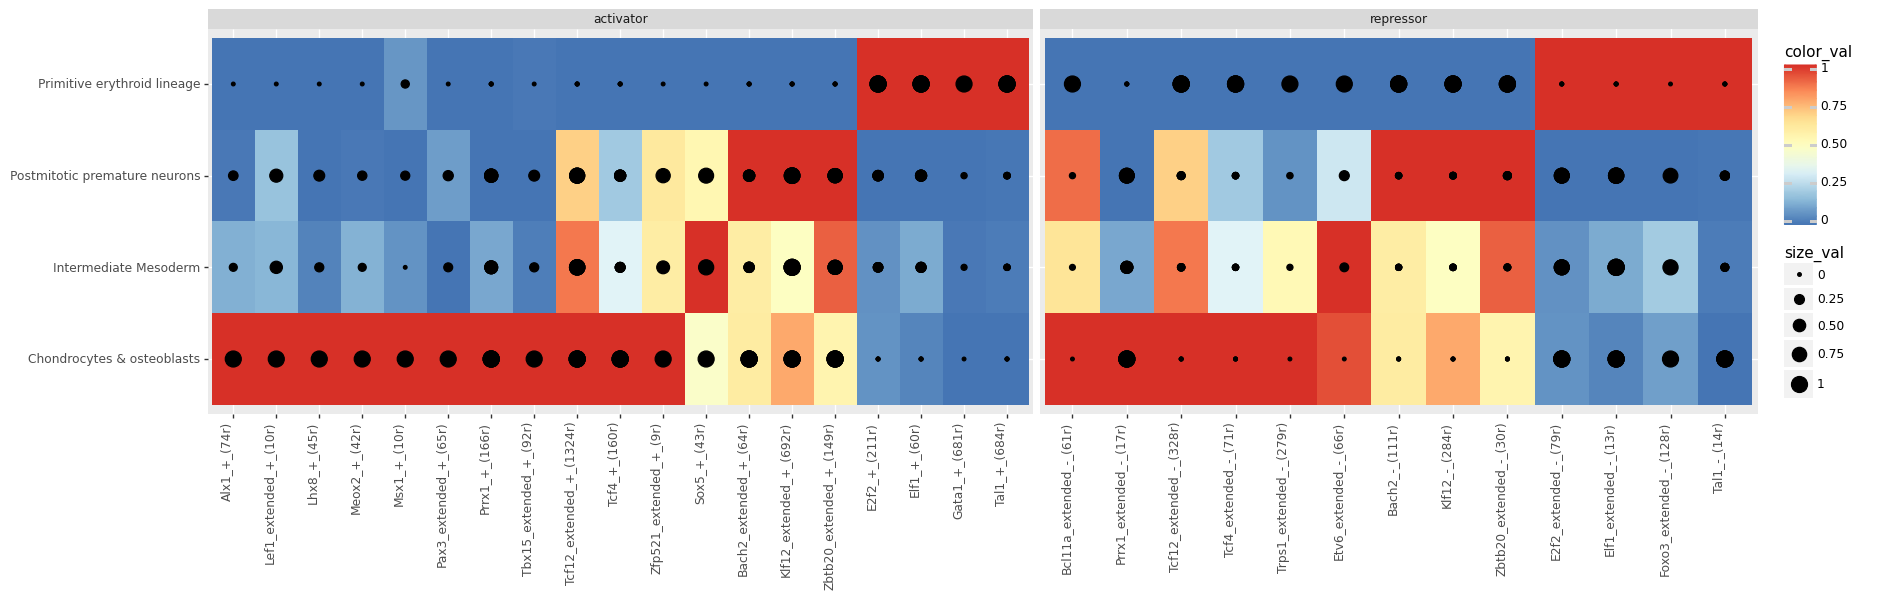

<ggplot: (8763977817495)>

In [37]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], #specify what to plot as dot sizes, target region enrichment in this case
#         size_matrix = scplus_obj.uns['eRegulon_AUC']['Region_based'],
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'predictedGroup_Un',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
#         index_order = ['MM001', 'MM011', 'MM031', 'MM087', 'MM074', 'MM057', 'MM047', 'MM029', 'MM099'],
        figsize = (20, 5),
        orientation = 'horizontal')

# overlap of predicted target regions

In [38]:
from scenicplus.RSS import *
regulon_specificity_scores(
        scplus_obj,
        variable = 'predictedGroup_Un',
        auc_key = 'eRegulon_AUC_filtered',
#         auc_key = 'eRegulon_AUC',
        signature_keys = ['Region_based'],
        selected_regulons = [x for x in scplus_obj.uns['selected_eRegulon']['Region_based'] if '-' not in x],
        out_key_suffix = '_filtered')

In [39]:
scplus_obj.uns['RSS'].keys()

dict_keys(['predictedGroup_Un_gene_based', 'predictedGroup_Un_region_based', 'predictedGroup_Un_filtered'])

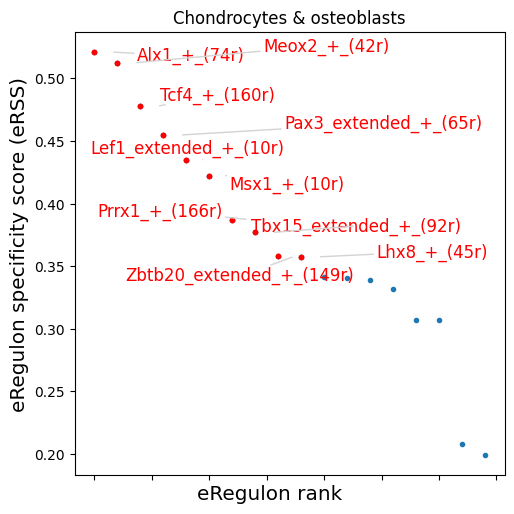

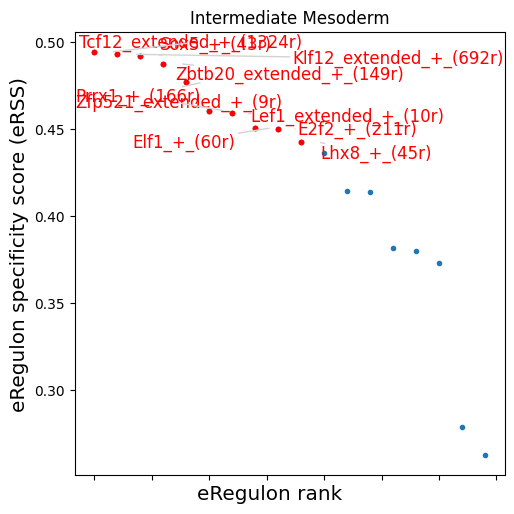

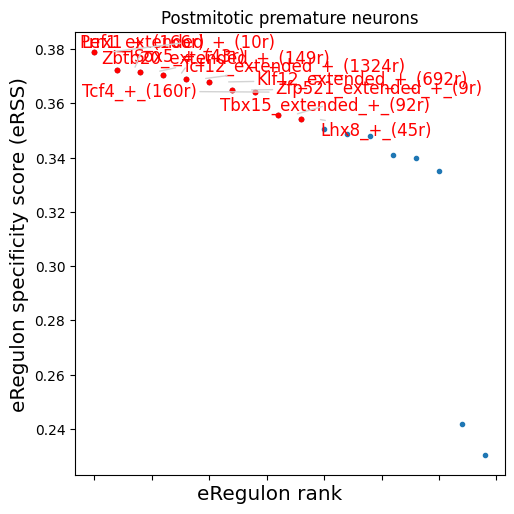

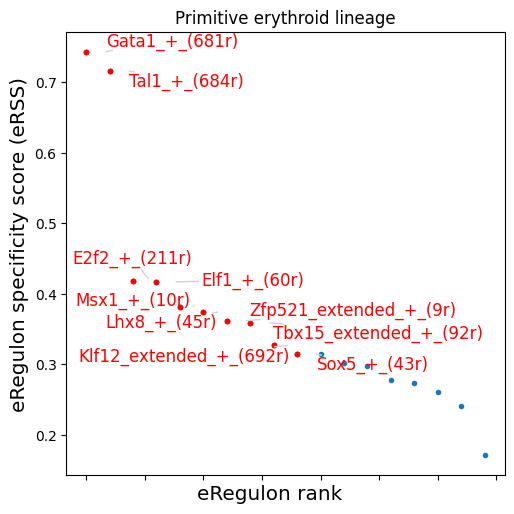

In [40]:
plot_rss(scplus_obj, 'predictedGroup_Un_filtered', num_columns=1, top_n=10, figsize = (5, 5))


In [41]:
flat_list = lambda t: [item for sublist in t for item in sublist]
selected_markers = list(set(flat_list(
    [scplus_obj.uns['RSS']['predictedGroup_Un_filtered'].loc[celltype].sort_values(
        ascending = False).head(10).index.to_list()
    for celltype in scplus_obj.uns['RSS']['predictedGroup_Un_filtered'].index])))

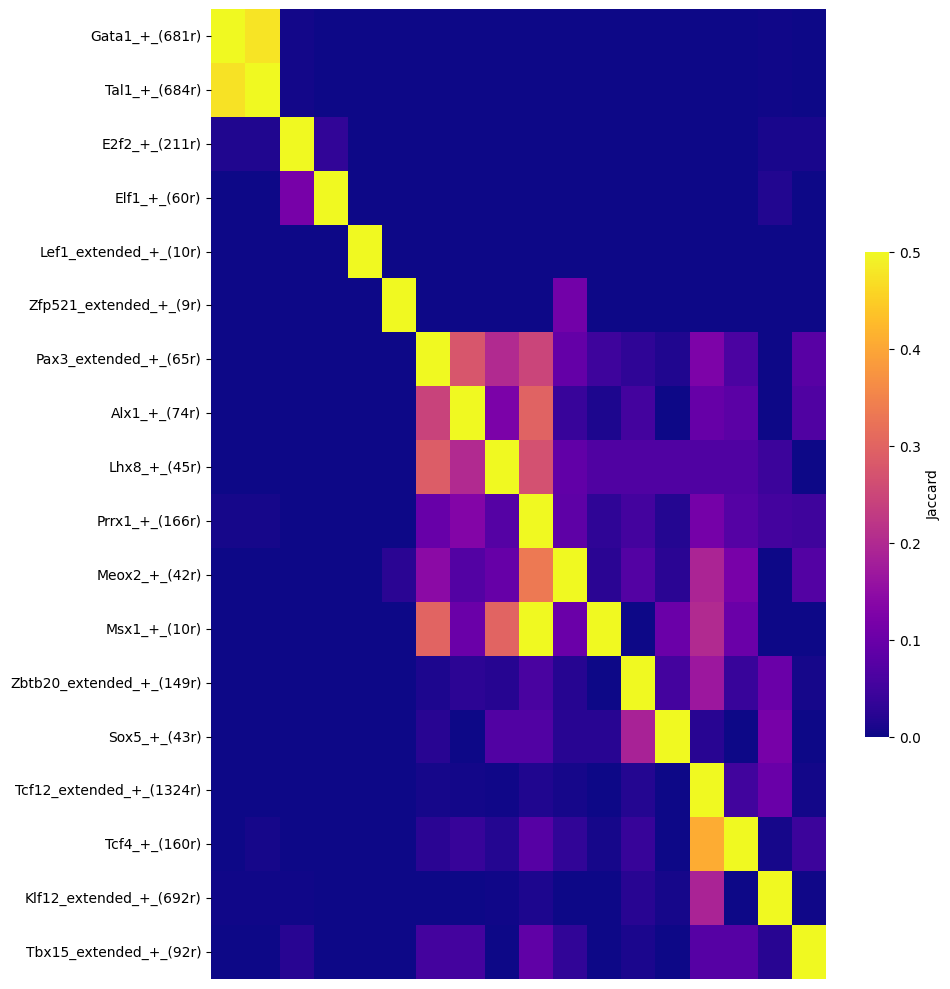

In [42]:
from scenicplus.plotting.correlation_plot import *

region_intersetc_data, Z = jaccard_heatmap(
        scplus_obj,
        method = 'intersect',
        gene_or_region_based = 'Region_based',
        use_plotly = False,
        selected_regulons = selected_markers,
        signature_key = 'eRegulon_signatures_filtered',
#         signature_key = 'eRegulon_signatures',
    
        figsize = (10, 10), return_data = True, vmax = 0.5, cmap = 'plasma')

# Plotting a network

In [404]:
from pycisTopic.diff_features import find_highly_variable_features
hvr = find_highly_variable_features(scplus_obj.to_df('ACC').loc[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Region']))], n_top_features=1000, plot = False)
hvg = find_highly_variable_features(scplus_obj.to_df('EXP')[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Gene']))].T, n_top_features=1000, plot = False)

2023-02-01 13:57:00,178 cisTopic     INFO     Calculating mean
2023-02-01 13:57:00,186 cisTopic     INFO     Calculating variance
2023-02-01 13:57:00,340 cisTopic     INFO     Done!
2023-02-01 13:57:00,363 cisTopic     INFO     Calculating mean
2023-02-01 13:57:00,367 cisTopic     INFO     Calculating variance
2023-02-01 13:57:00,450 cisTopic     INFO     Done!


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [405]:
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
nx_tables = create_nx_tables(
    scplus_obj = scplus_obj,
    eRegulon_metadata_key ='eRegulon_metadata_filtered',
#     eRegulon_metadata_key ='eRegulon_metadata',
#     subset_eRegulons = [one, two, three],
    subset_regions = hvr,
    subset_genes = hvg,
    add_differential_gene_expression = True,
    add_differential_region_accessibility = True
   , differential_variable = ['predictedGroup_Un']
)

... storing 'predictedGroup_Un' as categorical
... storing 'predictedGroup_Un' as categorical
... storing 'predictedGroup_Un' as categorical


In [313]:
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
nx_tables2 = create_nx_tables(
    scplus_obj = scplus_obj,
    eRegulon_metadata_key ='eRegulon_metadata_filtered',
#     eRegulon_metadata_key ='eRegulon_metadata',
    subset_eRegulons = [one, two, three],
    subset_regions = hvr,
    subset_genes = hvg,
    add_differential_gene_expression = True,
    add_differential_region_accessibility = True
   , differential_variable = ['predictedGroup_Un']
)

... storing 'predictedGroup_Un' as categorical
... storing 'predictedGroup_Un' as categorical
... storing 'predictedGroup_Un' as categorical


In [314]:
nx_tables2['Node']['TF']

,Node_type,TF,predictedGroup_Un_Log2FC_Chondrocytes & osteoblasts,predictedGroup_Un_Log2FC_Intermediate Mesoderm,predictedGroup_Un_Log2FC_Postmitotic premature neurons,predictedGroup_Un_Log2FC_Primitive erythroid lineage
Gata1,TF,Gata1,-28.303890,-6.261206,-28.404890,8.760698
Tal1,TF,Tal1,-5.398974,-4.753572,-6.138796,7.124549


In [421]:
lst_of_tf = nx_tables['Node']['TF'].index.tolist()

from random import randint
color = []
n = len(lst_of_tf)
for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))
    
category_color = {lst_of_tf[i]: color[i] for i in range(len(lst_of_tf))}
category_color

{'Gata1': '#5AF45A',
 'Hand2': '#D1DB14',
 'Batf': '#4A8079',
 'Mxi1': '#6A47D6',
 'Zbtb14': '#A361EC',
 'Tcf4': '#FF8E6E',
 'Six1': '#77C288',
 'Klf1': '#83E3F8',
 'Nfe2l1': '#3C0360',
 'Mta3': '#B93115',
 'Arid3a': '#5F3517',
 'Tal1': '#25103A',
 'Jun': '#934F49',
 'Pbx3': '#05B541',
 'Sin3a': '#186934',
 'Trps1': '#ACC446',
 'Nr3c1': '#6EC1C7',
 'Tcf12': '#C102C5',
 'Mxd3': '#CC56F1',
 'Bcl11a': '#AC6B04',
 'Ldb1': '#CC7F7B',
 'Tcf3': '#C599EC',
 'Acaa1a': '#D4005A',
 'Sox5': '#BDF0A5',
 'Wt1': '#2F71B2',
 'Zfp566': '#5CC994',
 'Phf20': '#133F53',
 'Sp7': '#BEF947',
 'Rara': '#CC12A9',
 'E2f2': '#E35088',
 'Sp4': '#75DE0F',
 'E2f4': '#9F7247',
 'E2f3': '#73BC47',
 'Taf1': '#9F0E5B',
 'Plagl2': '#3624B2',
 'Usf2': '#A0BBCF',
 'Nfe2': '#6FECDB',
 'Ets1': '#7FDB60',
 'Klf3': '#C46143',
 'Klf5': '#97BEB1',
 'Arnt': '#E051F7',
 'Bach1': '#29066A',
 'Cnot3': '#E02965',
 'Zfp560': '#D79B9E',
 'Erf': '#832E4A',
 'Klf12': '#23ACA8',
 'Prrx1': '#960800',
 'Hes1': '#A42520',
 'Tfeb': '#F4463D'

In [449]:
G, pos, edge_tables, node_tables = create_nx_graph(nx_tables,
                   use_edge_tables = ['TF2R','TF2G'],
                   color_edge_by = {
#                                     'TF2R': {'variable' : 'TF', 'category_color' : {one: 'Green', two: 'Blue', three: 'Red'}},
                                    'TF2R': {'variable' : 'TF', 'category_color' : category_color},
                                    'TF2G': {'variable' : 'TF2G_rho', 'continuous_color' : 'viridis', 'v_min': -1, 'v_max': 1}},
                   transparency_edge_by =  {'R2G': {'variable' : 'TF2G_importance', 'min_alpha': 0.1, 'v_min': 0}},
                   width_edge_by = {'TF2G': {'variable' : 'TF2G_importance', 'max_size' :  1.5, 'min_size' : 1}},
                   color_node_by = {
#                                     'TF': {'variable': 'TF', 'category_color' : {one: 'Green', two: 'Blue', three: 'Red'}},
                                    'TF': {'variable': 'TF', 'category_color' : category_color},
                                    'Gene': {'variable': 'predictedGroup_Un_Log2FC_Chondrocytes & osteoblasts', 'continuous_color' : 'bwr'},
                                    'Region': {'variable': 'predictedGroup_Un_Log2FC_Chondrocytes & osteoblasts', 'continuous_color' : 'viridis'}},
                   transparency_node_by =  {'Region': {'variable' : 'predictedGroup_Un_Log2FC_Chondrocytes & osteoblasts', 'min_alpha': 0.1},
                                    'Gene': {'variable' : 'predictedGroup_Un_Log2FC_Chondrocytes & osteoblasts', 'min_alpha': 0.1}
                                   },
                                                   
                                                   
                   size_node_by = {'TF': {'variable': 'fixed_size', 'fixed_size': 30},
                                    'Gene': {'variable': 'fixed_size', 'fixed_size': 10},
                                    'Region': {'variable': 'fixed_size', 'fixed_size': 1}},
                   shape_node_by = {'TF': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Gene': {'variable': 'fixed_shape', 'fixed_shape': 'rectangle'},
                                    'Region': {'variable': 'fixed_shape', 'fixed_shape': 'diamond'}},
                   label_size_by = {'TF': {'variable': 'fixed_label_size', 'fixed_label_size': 20.0},
                                    'Gene': {'variable': 'fixed_label_size', 'fixed_label_size': 10.0},
                                    'Region': {'variable': 'fixed_label_size', 'fixed_label_size': 0.0}},
                   layout='kamada_kawai_layout',
                   scale_position_by=250)

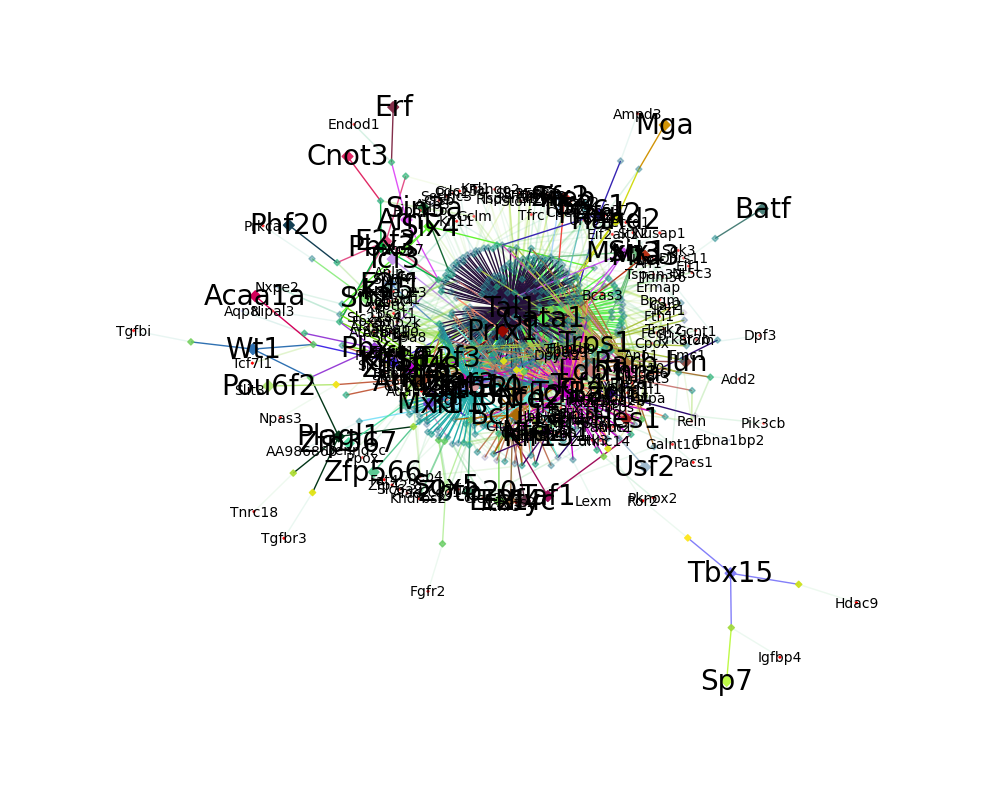

In [423]:
plt.figure(figsize=(10,8))
plot_networkx(G, pos)

In [450]:
export_to_cytoscape(G, pos, out_file = os.path.join(work_dir, 'scenicplus/network_Chondrocytes.cys'))


In [447]:
G, pos, edge_tables, node_tables = create_nx_graph(nx_tables,
                   use_edge_tables = ['TF2R','TF2G'],
                   color_edge_by = {
#                                     'TF2R': {'variable' : 'TF', 'category_color' : {one: 'Green', two: 'Blue', three: 'Red'}},
                                    'TF2R': {'variable' : 'TF', 'category_color' : category_color},
                                    'TF2G': {'variable' : 'TF2G_rho', 'continuous_color' : 'viridis', 'v_min': -1, 'v_max': 1}},
                   transparency_edge_by =  {'TF2G': {'variable' : 'TF2G_importance', 'min_alpha': 0.1, 'v_min': 0}},
                   width_edge_by = {'TF2G': {'variable' : 'TF2G_importance', 'max_size' :  1.5, 'min_size' : 1}},
                   color_node_by = {
#                                     'TF': {'variable': 'TF', 'category_color' : {one: 'Green', two: 'Blue', three: 'Red'}},
                                    'TF': {'variable': 'TF', 'category_color' : category_color},
                                    'Gene': {'variable': 'predictedGroup_Un_Log2FC_Primitive erythroid lineage', 'continuous_color' : 'bwr'},
                                    'Region': {'variable': 'predictedGroup_Un_Log2FC_Primitive erythroid lineage', 'continuous_color' : 'viridis'}},
                   transparency_node_by =  {'Region': {'variable' : 'predictedGroup_Un_Log2FC_Primitive erythroid lineage', 'min_alpha': 0.1},
                                    'Gene': {'variable' : 'predictedGroup_Un_Log2FC_Primitive erythroid lineage', 'min_alpha': 0.1}
                                   },
                                                   
                                                   
                   size_node_by = {'TF': {'variable': 'fixed_size', 'fixed_size': 30},
                                    'Gene': {'variable': 'fixed_size', 'fixed_size': 10},
                                    'Region': {'variable': 'fixed_size', 'fixed_size': 1}},
                   shape_node_by = {'TF': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Gene': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Region': {'variable': 'fixed_shape', 'fixed_shape': 'diamond'}},
                   label_size_by = {'TF': {'variable': 'fixed_label_size', 'fixed_label_size': 20.0},
                                    'Gene': {'variable': 'fixed_label_size', 'fixed_label_size': 10.0},
                                    'Region': {'variable': 'fixed_label_size', 'fixed_label_size': 0.0}},
                   layout='kamada_kawai_layout',
                   scale_position_by=250)

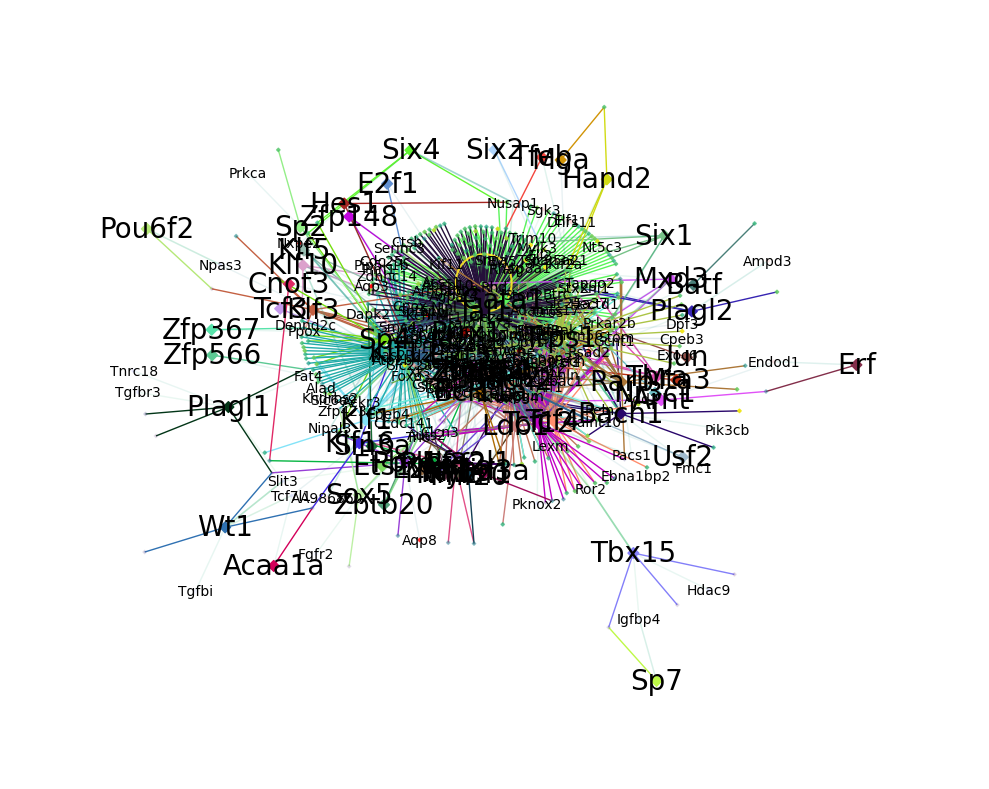

In [437]:
plt.figure(figsize=(10,8))
plot_networkx(G, pos)

In [448]:
export_to_cytoscape(G, pos, out_file = os.path.join(work_dir, 'scenicplus/network_Primitive_erythro.cys'))

# velocyto

# Perturbation simulation

In [43]:
work_dir = "projDir/"
# Temp dir
tmp_dir = "/home/ec2-user/"


In [56]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
import numpy as np
work_dir = work_dir
tmp_dir = tmp_dir

if not os.path.exists(work_dir):
    os.makedirs(work_dir)

In [53]:
import dill
scplus_obj = dill.load(open('./projDir/scenicplus/scplus_obj.pkl', 'rb'))
scplus_obj

SCENIC+ object with n_cells x n_genes = 1298 x 15460 and n_cells x n_regions = 1298 x 320682
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'predictedGroup_Un'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_DARs_state_All', 'CTX_DARs_state_No_promoters', 'DEM_DARs_state_All', 'DEM_DARs_state_No_promoters'
	dr_cell:'eRegulons_UMAP', 'eRegulons_tSNE'

In [61]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function

score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 3)
score_eRegulons(scplus_obj,
                ranking = gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 3)

from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'predictedGroup_Un',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'predictedGroup_Un',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based')

####    Get correlation between gene expression and cistrome accessibility

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'predictedGroup_Un',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'predictedGroup_Un',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

thresholds = {
        'rho': [-0.5, 0.5],
        'n_targets': 0
}

selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...
selected: 61 eRegulons


In [57]:
scplus_obj.uns.keys()

dict_keys(['Cistromes', 'search_space', 'region_to_gene', 'TF2G_adj', 'eRegulons', 'eRegulon_metadata', 'eRegulon_signatures', 'eRegulon_AUC', 'eRegulon_AUC_thresholds', 'RSS'])

In [52]:
scplus_obj.metadata_cell['predictedGroup_Un'].value_counts()

Intermediate Mesoderm            474
Primitive erythroid lineage      372
Postmitotic premature neurons    260
Chondrocytes & osteoblasts       192
Name: predictedGroup_Un, dtype: int64

In [55]:
scplus_obj.metadata_cell.shape

(1298, 1)

In [62]:
from scenicplus.dimensionality_reduction import run_eRegulons_pca
run_eRegulons_pca(
        scplus_obj,
        auc_key = 'eRegulon_AUC_filtered',
        reduction_name = 'eRegulons_PCA_gene_based',
        selected_regulons = scplus_obj.uns['selected_eRegulon']['Gene_based'])

In [63]:
from scenicplus.dimensionality_reduction import run_eRegulons_umap


run_eRegulons_umap(
        scplus_obj,
        auc_key = 'eRegulon_AUC_filtered',
        reduction_name = 'eRegulons_Umap_gene_based',
        selected_regulons = scplus_obj.uns['selected_eRegulon']['Gene_based'])

In [64]:
scplus_obj.dr_cell.keys()

dict_keys(['eRegulons_UMAP', 'eRegulons_tSNE', 'eRegulons_PCA_gene_based', 'eRegulons_Umap_gene_based'])

In [114]:
spatial_map = pd.read_csv('spatial_map_filtered.csv', index_col=0)
spatial_map.index = scplus_obj.dr_cell['eRegulons_Umap_gene_based'].index
spatial_map

,Spatial_1,Spatial_2,predictedGroup_Un
Chondrocytes & osteoblasts_0,391.269491,-665.381443,Chondrocytes & osteoblasts
Chondrocytes & osteoblasts_1,391.495586,-795.625558,Chondrocytes & osteoblasts
Chondrocytes & osteoblasts_2,391.947778,-1056.113788,Chondrocytes & osteoblasts
Chondrocytes & osteoblasts_3,392.513017,-1381.724076,Chondrocytes & osteoblasts
Chondrocytes & osteoblasts_4,521.513606,-664.703156,Chondrocytes & osteoblasts
...,...,...,...
Primitive erythroid lineage_367,3390.501670,-2733.686681,Primitive erythroid lineage
Primitive erythroid lineage_368,2608.697836,-2542.390231,Primitive erythroid lineage
Primitive erythroid lineage_369,2934.647267,-2736.060686,Primitive erythroid lineage
Primitive erythroid lineage_370,2218.304634,-2739.791265,Primitive erythroid lineage


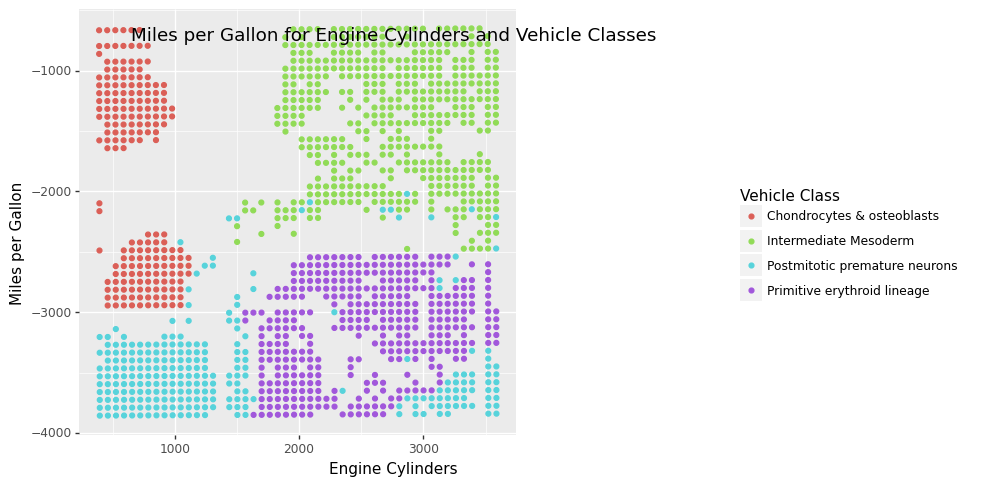

<ggplot: (8764306067119)>

In [116]:
# from plotnine.data import mpg
from plotnine import ggplot, aes, labs, geom_point, theme


ggplot(spatial_map)+ aes(x="Spatial_1", y="Spatial_2", color="predictedGroup_Un")+ labs(
        x="Engine Cylinders",
        y="Miles per Gallon",
        color="Vehicle Class",
        title="Miles per Gallon for Engine Cylinders and Vehicle Classes",
    )+ geom_point() + theme(figure_size=(8, 5))



In [123]:
# drop annotaion column
scplus_obj.dr_cell['spatial_map'].drop('predictedGroup_Un', axis=1, inplace=True)

scplus_obj.dr_cell['spatial_map'] = spatial_map

In [124]:
scplus_obj.dr_cell.keys()

dict_keys(['eRegulons_UMAP', 'eRegulons_tSNE', 'eRegulons_PCA_gene_based', 'eRegulons_Umap_gene_based', 'spatial_map'])

In [120]:
from pycisTopic.diff_features import find_highly_variable_features
hvg = find_highly_variable_features(scplus_obj.to_df('EXP')[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Gene']))].T, n_top_features = 200, plot = False)


2023-02-02 15:27:11,573 cisTopic     INFO     Calculating mean
2023-02-02 15:27:11,580 cisTopic     INFO     Calculating variance
2023-02-02 15:27:11,703 cisTopic     INFO     Done!


<Figure size 640x480 with 0 Axes>

In [121]:
# 'Alx4': 0, 'Tcf4': 1,'Etv6': 2,'Pax5': 3,'Zfp367': 4

2023-02-02 15:36:03,718 perturbation INFO     Caclulating perturbation matrix for: {'Alx4': 0, 'Tcf4': 0, 'Etv6': 0, 'Pax5': 0, 'Zfp367': 0} over 5 iterations.
2023-02-02 15:36:54,590 perturbation INFO     Generating ranking based on perturbed matrix.
2023-02-02 15:36:56,974 perturbation INFO     Scoring eRegulons.
2023-02-02 15:37:07,855 perturbation INFO     Projecting perturbation effect in embedding: spatial_map
2023-02-02 15:37:08,336 perturbation INFO     Calculating grid of arrows
2023-02-02 15:37:08,419 perturbation INFO     Plotting


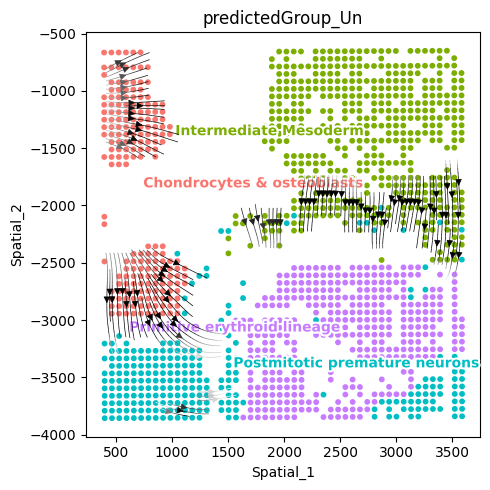

In [127]:
color_dict_line = {
    'Chondrocytes & osteoblasts': '#F8766D',
    'Intermediate Mesoderm': '#7CAE00',
    'Postmitotic premature neurons': '#00BFC4',
#     'MM074': '#222E50',
#     'MM087': '#8BB174',
#     'MM057': '#2A4849',
#     'MM029': '#3E5641',
#     'MM047': '#59A96A',
    'Primitive erythroid lineage': '#C77CFF'}

from scenicplus.simulation import plot_perturbation_effect_in_embedding
import seaborn as sns
_ = plot_perturbation_effect_in_embedding(
        scplus_obj = scplus_obj,
        reduction_name = 'spatial_map',
#         eRegulon_signatures_key = 'eRegulon_signatures_filtered',
#         AUC_key = 'eRegulon_AUC_filtered',
#         eRegulon_metadata_key = 'eRegulon_metadata_filtered',
        n_cpu = 5,
        perturbation = {'Alx4': 0, 'Tcf4': 0,'Etv6': 0,'Pax5': 0,'Zfp367': 0}, #specifies that we want to set the expression of SOX10 to 0 in all cells.
        variable = 'predictedGroup_Un',
        color_dictionary = {'predictedGroup_Un': color_dict_line},
        genes_to_use = hvg,
        figsize = (5, 5))
